# EURO Simulation

**Summary**: This past month we were withness to the sporting spectecal that is the EUROs. It is an event that takes place every 4 years (5 years this time cause COVID) where the best Countries qualify to compete. In this notebook we will be looking at the round of 16 onwards. Using the results in the group stage to predict the winner of the tournament. 

The first step is to import the data and we will use that to calculate the weights that will be used to calculate the rest of the results. 

For this we will look at Wins, Loses, Draws, Goals For and Goals Against and the formula for calculating weights will be
sum(W_i*x_i)/sum(W) where W are the weights and x is the value of said weight. Where the weights are valued at 
Win = 1 Lose = -1 Draw = 0.5 Goals For = 0.25 Goals Against = -0.25. Wins are more important than loses and both are more important than draws. And the result of the match is more important than the actual goals but teams are still punished for heavy concedings. 

In [197]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml
import sklearn.datasets
import sklearn.decomposition
import torch
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (10,8)

In [198]:
def weightFunc(row):
    return row['Won'] - row['Lost'] + row['Draw']*0.5 +row['GF']*.25 - row['A']*.25

def whoWon(value):
    v_list = value.split(' - ')
    if v_list[0] == v_list[1]:
        return np.random.randint(0, 1)
    if v_list[0] > v_list[1]:
        return 1
    else:
        return 0

In [199]:
df = pd.read_csv('data/prem_table_2020.csv')
df.keys()
df['Weight'] =df.apply (lambda row: weightFunc(row),axis=1)
df = df[['Team','Weight']]
df = df.replace(to_replace ='Manchester City', value ='Man City')
df = df.replace(to_replace ='Leicester City',value ='Leicester')
df = df.replace('Sheffield United',value ='Sheffield Utd')
df = df.replace('Norwich City',value ='Norwich')
df = df.replace('Wolverhampton Wanderers',value ='Wolves')
df = df.replace('West Ham United',value ='West Ham')
df = df.replace('Tottenham Hotspur',value ='Spurs')
df = df.replace('Newcastle United',value ='Newcastle')
df = df.replace('Manchester United',value ='Man Utd')
df = df.replace('Brighton and Hove Albion',value ='Brighton')
df

,Team,Weight
0,Liverpool,37.00
1,Man City,20.50
2,Leicester,18.50
3,Chelsea,8.75
4,Spurs,8.75
5,Sheffield Utd,8.50
6,Wolves,8.75
7,Everton,2.00
8,Man Utd,6.75
9,Arsenal,8.00


In [200]:
df_matches = pd.read_csv('data/epl-2019-GMTStandardTime.csv')
df_matches = df_matches[['Home Team','Away Team','Result']]
teams = df_matches['Home Team'].unique()

In [201]:
df_matches['y'] = df_matches['Result'].apply (lambda value: whoWon(value))
for team in teams:
    index = df.index
    cond = df['Team'] == team
    i = index[cond].tolist()[0]
    df_matches = df_matches.replace(team,df['Weight'][i])
df_matches['x'] = df_matches[['Home Team', 'Away Team']].values.tolist()
df_matches = df_matches[['x','y']]
df_matches

,x,y
0,"[37.0, -15.0]",1
1,"[-7.25, 20.5]",0
2,"[-8.0, 8.5]",0
3,"[-2.25, -6.0]",1
4,"[-0.75, 2.0]",0
...,...,...
375,"[18.5, 6.75]",0
376,"[20.5, -15.0]",1
377,"[-3.5, 37.0]",0
378,"[-6.0, 8.5]",1


In [202]:
n_features = 2
n_classes = 2
n_samples = 380
x = df_matches['x'].values.tolist()
y = df_matches['y'].values.tolist()

In [203]:
np.random.seed(1967)
x, y = zip(*np.random.permutation(list(zip(x, y))))

pca = sklearn.decomposition.PCA(n_components=n_features)
pca.fit(x)
x = pca.transform(x)

In [204]:
x_min = np.min(x, axis=0)
x_max = np.max(x, axis=0)

x = 2 * np.pi * (x - x_min) / (x_max - x_min) - np.pi

In [205]:
split = int(n_samples*90)

x_train = x[:split]
x_test = x[split:]
y_train = y[:split]
y_test = y[split:]

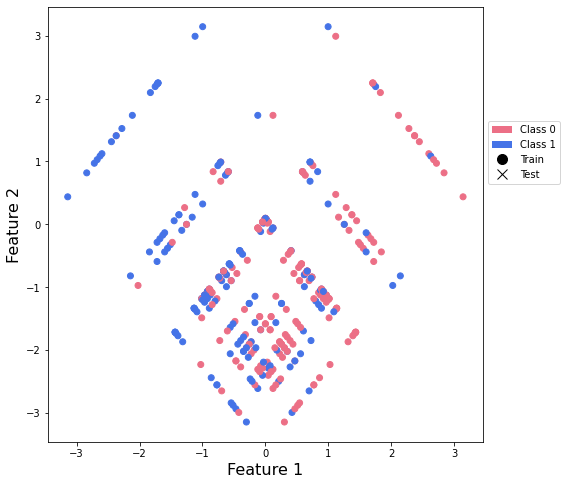

In [206]:
colours = ["#ec6f86", "#4573e7"]
def plot_points(x_train, y_train, x_test, y_test):
    c_train = []
    c_test = []

    for y in y_train:
        c_train.append(colours[y])

    for y in y_test:
        c_test.append(colours[y])

    plt.scatter(x_train[:, 0], x_train[:, 1], c=c_train)
    plt.scatter(x_test[:, 0], x_test[:, 1], c=c_test, marker="x")

    plt.xlabel("Feature 1", fontsize=16)
    plt.ylabel("Feature 2", fontsize=16)

    ax = plt.gca()
    ax.set_aspect(1)

    c_transparent = "#00000000"

    custom_lines = [
        Patch(facecolor=colours[0], edgecolor=c_transparent, label="Class 0"),
        Patch(facecolor=colours[1], edgecolor=c_transparent, label="Class 1"),
        Line2D([0], [0], marker="o", color=c_transparent, label="Train",
               markerfacecolor="black", markersize=10),
        Line2D([0], [0], marker="x", color=c_transparent, label="Test",
               markerfacecolor="black", markersize=10),
    ]

    ax.legend(handles=custom_lines, bbox_to_anchor=(1.0, 0.75))


plot_points(x_train, y_train, x_test, y_test)

Now using the model that we trained on premier leauge data we will predict the results of the Euros playoffs (round of 16 to the final). We will use the results of the group stage to calculate the different weights

In [207]:
n_wires = 3

#dev0 = qml.device("forest.qvm", device="4q-qvm")
dev1 = qml.device("qiskit.aer", wires=4)

In [238]:
def circuit0(params, x=None):
    for i in range(n_wires):
        qml.RX(x[i % n_features], wires=i)
        qml.Rot(*params[1, 0, i], wires=i)

    qml.CZ(wires=[1, 0])
    qml.CZ(wires=[1, 2])
    qml.CZ(wires=[3, 0])

    for i in range(n_wires):
        qml.Rot(*params[1, 1, i], wires=i)
    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1)), qml.expval(qml.PauliZ(2))


def circuit1(params, x=None):
    for i in range(n_wires):
        qml.RX(x[i % n_features], wires=i)
        qml.Rot(*params[0, i], wires=i)

    qml.CZ(wires=[0, 1])
    qml.CZ(wires=[1, 2])

    for i in range(n_wires):
        qml.Rot(*params[1, i], wires=i)
    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1))

In [231]:
qnodes = qml.QNodeCollection(
    [qml.QNode(circuit1, dev1, interface="torch")]
)

In [242]:
def decision(softmax):
    return int(torch.argmax(softmax))


def predict_point(params, x_point=None, parallel=True):
    results = qnodes(params, x=x_point, parallel=False)
    softmax = torch.nn.functional.softmax(results, dim=1)
    choice = torch.where(softmax == torch.max(softmax))[0][0]
    chosen_softmax = softmax[choice]
    return decision(chosen_softmax), decision(softmax[0]), int(choice)

In [247]:
def predict(params, x=None, parallel=True):
    predictions_ensemble = []
    predictions_0 = []
    predictions_1 = []
    choices = []

    for i, x_point in enumerate(x):
        if i % 10 == 0 and i > 0:
            print("Completed up to iteration {}".format(i))
        results = predict_point(params, x_point=x_point, parallel=parallel)
        predictions_ensemble.append(results[0])
        predictions_0.append(results[1])
        choices.append(results[2])

    return predictions_ensemble, predictions_0, choices

In [248]:
df_Euro = pd.read_csv('data/euroGroupStage.csv')
df_Euro.columns = ['Team','Won','Draw','Lost','GF','A']
df_Euro['Weight'] =df_Euro.apply (lambda row: weightFunc(row),axis=1)
df_Euro =  df_Euro[['Team','Weight']]
df_Euro

,Team,Weight
0,Italy,4.75
1,Wales,0.75
2,Switzerland,0.25
3,Belgium,4.50
4,Denmark,-0.75
5,Netherlands,4.50
6,Austria,1.25
7,Ukraine,-1.25
8,England,3.00
9,Croatia,0.75


Now that we have the weights for each team in the round of 16 we will look at the match ups and predict the winners of the round of 16. 

In [275]:
df_ro16 = pd.read_csv('data/roundOf16.csv')   
df_ro16
x_ro16 = df_ro16['x'].values.tolist()
x_ro16 = [list(map(float ,x.split(','))) for x in x_ro16]
df_ro16

,x
0,"0.75,-0.75"
1,"4.75,1.25"
2,"4.50,0.75"
3,"4.50,0.75"
4,"0.75, 3.25"
5,"2.25, 0.25"
6,"3.00,0.75"
7,"3.00,-1.25"


In [271]:
params = np.array(qml.init.strong_ent_layers_normal(n_layers=3, n_wires=3))
print("Predicting on training dataset")
p_train, p_train_0, choices_train = predict(params, x=x_train)
print("Predicting on test dataset")
p_test, p_test_0, choices_test = predict(params, x=x_ro16)

Predicting on training dataset
Completed up to iteration 10
Completed up to iteration 20
Completed up to iteration 30
Completed up to iteration 40
Completed up to iteration 50
Completed up to iteration 60
Completed up to iteration 70
Completed up to iteration 80
Completed up to iteration 90
Completed up to iteration 100
Completed up to iteration 110
Completed up to iteration 120
Completed up to iteration 130
Completed up to iteration 140
Completed up to iteration 150
Completed up to iteration 160
Completed up to iteration 170
Completed up to iteration 180
Completed up to iteration 190
Completed up to iteration 200
Completed up to iteration 210
Completed up to iteration 220
Completed up to iteration 230
Completed up to iteration 240
Completed up to iteration 250
Completed up to iteration 260
Completed up to iteration 270
Completed up to iteration 280
Completed up to iteration 290
Completed up to iteration 300
Completed up to iteration 310
Completed up to iteration 320
Completed up to it

In [274]:
p_test_0

[0, 1, 1, 1, 0, 1, 1, 1]

In [279]:
reults_ro16 = pd.read_csv('data/Matches.csv')   
reults_ro16

,Home Team,Away Team
0,Wales,Denmark
1,Italy,Austria
2,Netherland,Czech Republic
3,Belgium,Portugal
4,Croatia,Spain
5,France,Switzerland
6,England,Germany
7,Sweden,Ukraine
